# Libraries

In [189]:
from datasets import *
from train import *
from torchvision import datasets, transforms, models
from matplotlib.pyplot import figure

# Init Models

In [190]:
model = models.mobilenet_v3_large(weights='DEFAULT').to('cuda')
model64 = models.mobilenet_v3_large()
model64.load_state_dict(torch.load("best_modelsv3/best_batch_i1081020.pth")['model_state_dict'])
model64.to('cuda')
model.eval()
model64.eval()

activationT = {}
activationS = {}
def get_activationT(name):
    def hook(model, input, output):
        activationT[name] = output.detach()
    return hook
def get_activationS(name):
    def hook(model, input, output):
        activationS[name] = output.detach()
    return hook

model.classifier[0].register_forward_hook(get_activationT('emb'))
model64.classifier[0].register_forward_hook(get_activationS('emb'))

# Init Datasets

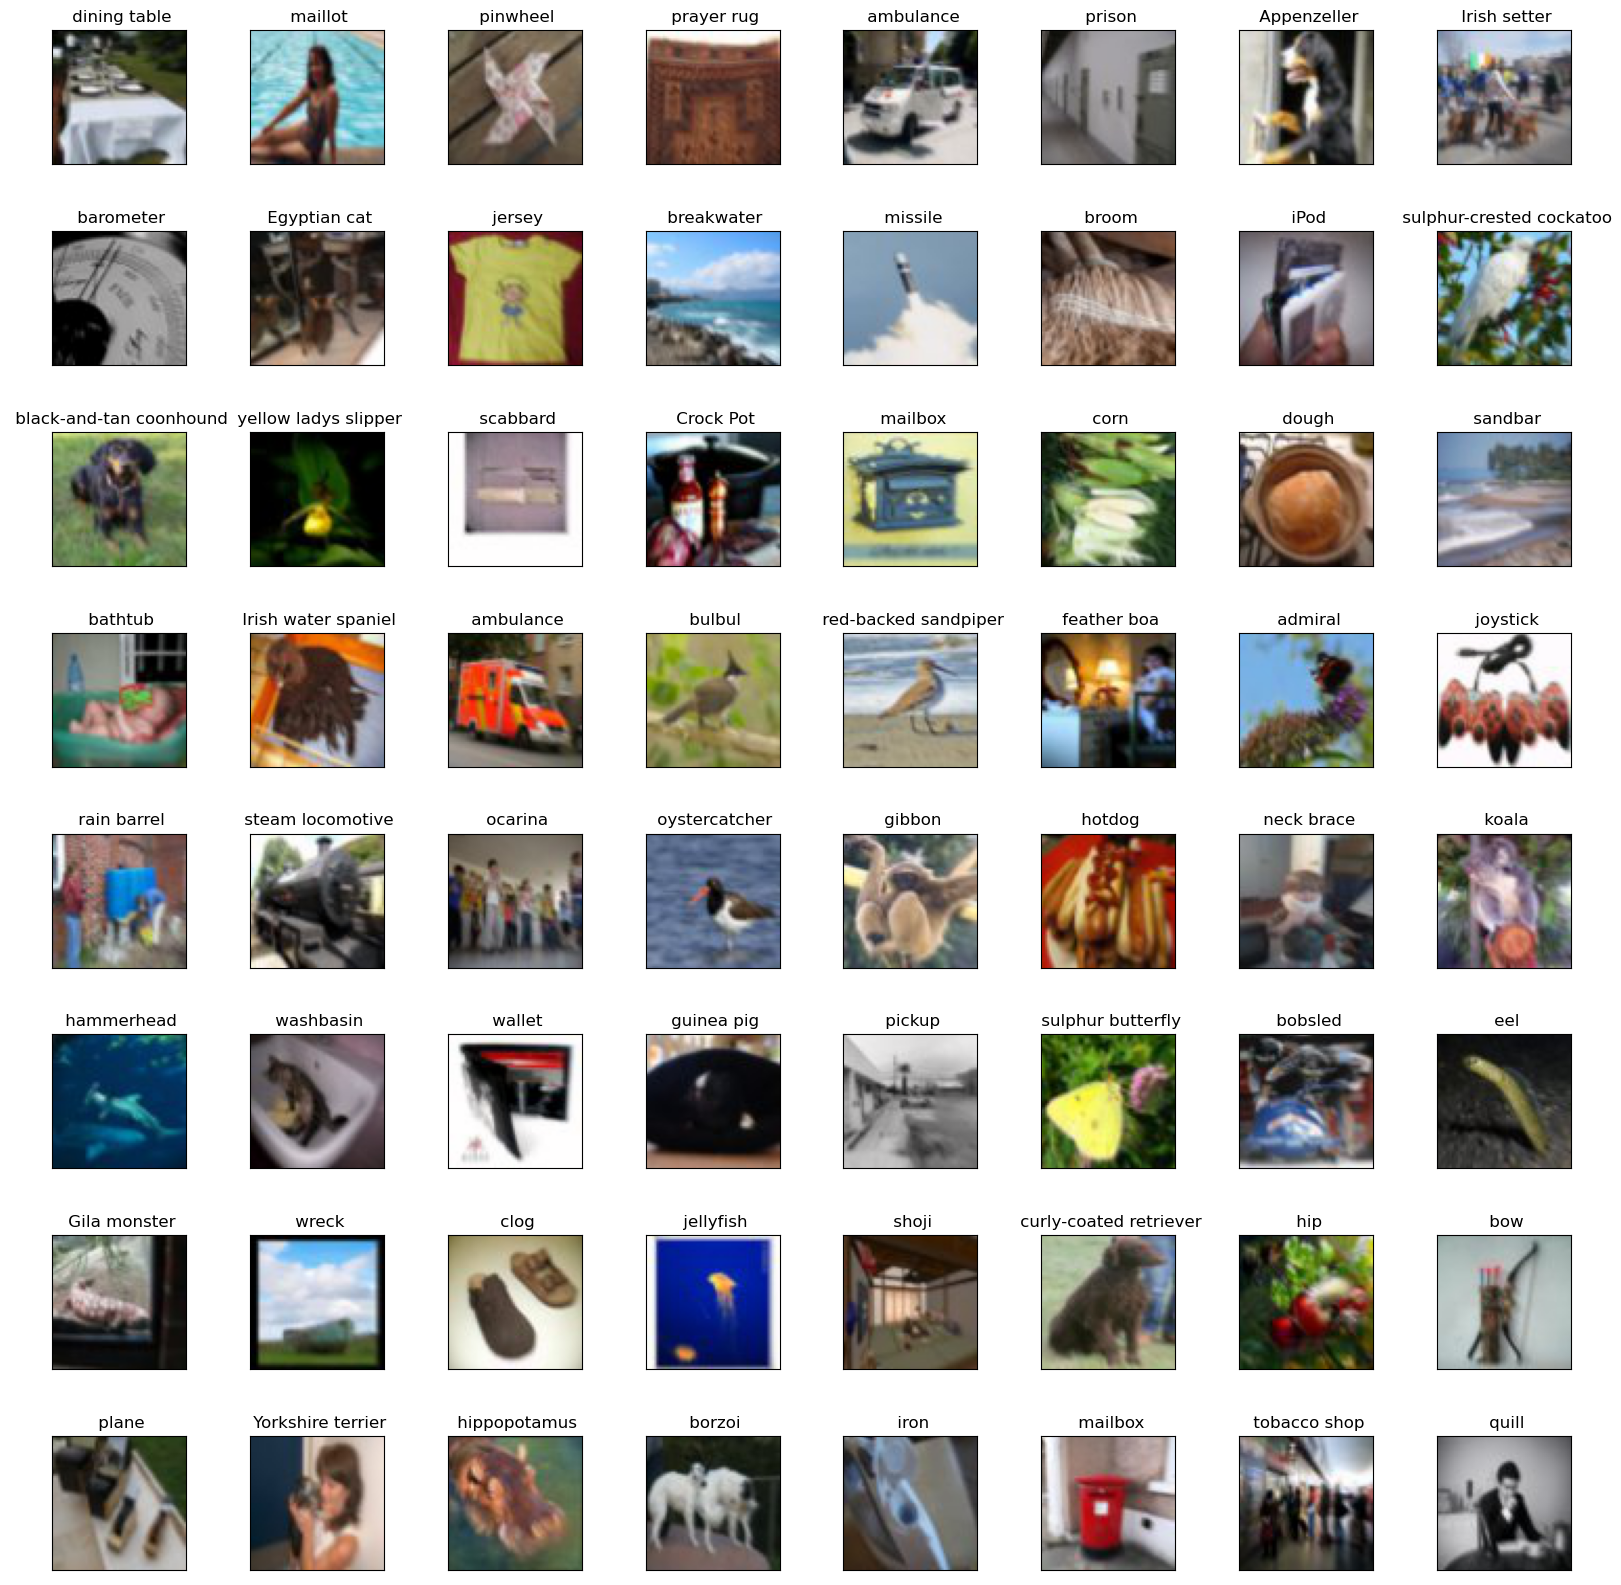

In [193]:
# rand_classes = torch.randperm(1000)[:10]
clean_val_loader = load_imagenet(256,1234,False)
clean_val_loader64 = load_imagenet64(256,1234,False)

corruptions = ['gaussian_noise','impulse_noise','shot_noise','defocus_blur','glass_blur','motion_blur','zoom_blur','snow','frost','fog','brightness','contrast','elastic_transform','jpeg_compression','pixelate']

corr_val_loaders = []
corr_val_loaders64 = []
for corr in corruptions:
    corr_val_loaders.append(load_imagenetc_val(128,1234,corr,severity=1,shuffle=True))
    corr_val_loaders64.append(load_imagenetc64_val(128,1234,corr,severity=1,shuffle=True))
visualize_batch(corr_val_loaders64[6])

# Pre-compute embeddings and save to disk

In [200]:
def save_embds(data_loader,file_name,model,activation):
    embds = torch.zeros((len(data_loader.dataset)),1280)
    labels = torch.zeros(len(data_loader.dataset))

    model.eval()
    with torch.no_grad():
        batch_idx = 0
        for (img_batch, label_batch) in tqdm(data_loader):
            img_batch, label_batch = img_batch.to('cuda'), label_batch.to('cuda')
            start = batch_idx*data_loader.batch_size
            end = start + len(label_batch)

            # get the embeddings
            model(img_batch)
            embd = activation['emb'].to('cpu')

            embds[start:end] = embd
            labels[start:end] = label_batch
            batch_idx += 1
    torch.save([embds,labels],file_name)

## Compute clean embeddings

In [197]:
save_embds(clean_val_loader,"embds/clean224.pt",model,activationT)

100%|██████████| 196/196 [04:20<00:00,  1.33s/it]


In [201]:
save_embds(clean_val_loader64,"embds/clean64.pt",model64,activationS)

100%|██████████| 196/196 [00:18<00:00, 10.39it/s]


## Corrupted Embeddings

In [202]:
for i,dl in enumerate(corr_val_loaders):
    save_embds(dl,"embds/corr224_" + corruptions[i] + ".pt",model,activationT)

100%|██████████| 391/391 [00:25<00:00, 15.52it/s]


In [203]:
for i,dl in enumerate(corr_val_loaders64):
    save_embds(dl,"embds/corr64_" + corruptions[i] + ".pt",model64,activationS)

100%|██████████| 391/391 [00:05<00:00, 68.95it/s]


# Class Centroids

In [227]:
def get_class_centroids(embds,labels):
    means = torch.zeros((1000,1280))
    stds = torch.zeros((1000,1280))
    for i,c in enumerate(torch.unique(labels)):
        idxs = (labels == c).nonzero().view(-1)
        c_embds = embds[idxs]
        means[i] = torch.mean(c_embds,dim=0)
        stds[i] = torch.std(c_embds,dim=0)
    return means,stds

In [243]:
embds,labels = torch.load("embds/clean224.pt")
means,stds = get_class_centroids(embds,labels)

embds64,labels64 = torch.load("embds/clean64.pt")
means64,stds64 = get_class_centroids(embds64,labels64)

corr_embds,corr_labels = torch.load("embds/corr224_gaussian_noise.pt")
corr_means,corr_stds = get_class_centroids(corr_embds,corr_labels)

corr_embds64,corr_labels64 = torch.load("embds/corr64_gaussian_noise.pt")
corr_means64,corr_stds64 = get_class_centroids(corr_embds64,corr_labels64)

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f7e313da8e0>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f7e313da880>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f7e313daf70>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f7e313dd370>,
 'cmedians': <matplotlib.collections.LineCollection at 0x7f7e313dd730>}

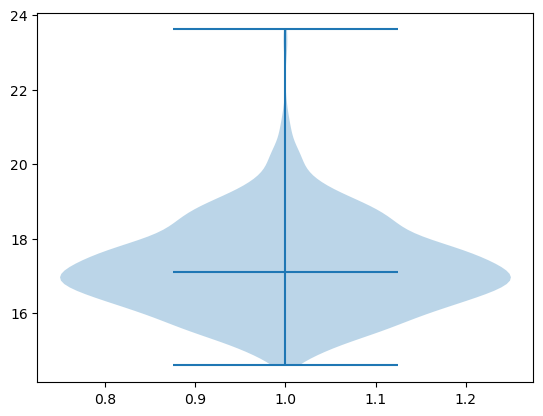

In [252]:
plt.violinplot(torch.norm(corr_means64,dim=1),showmedians=True)

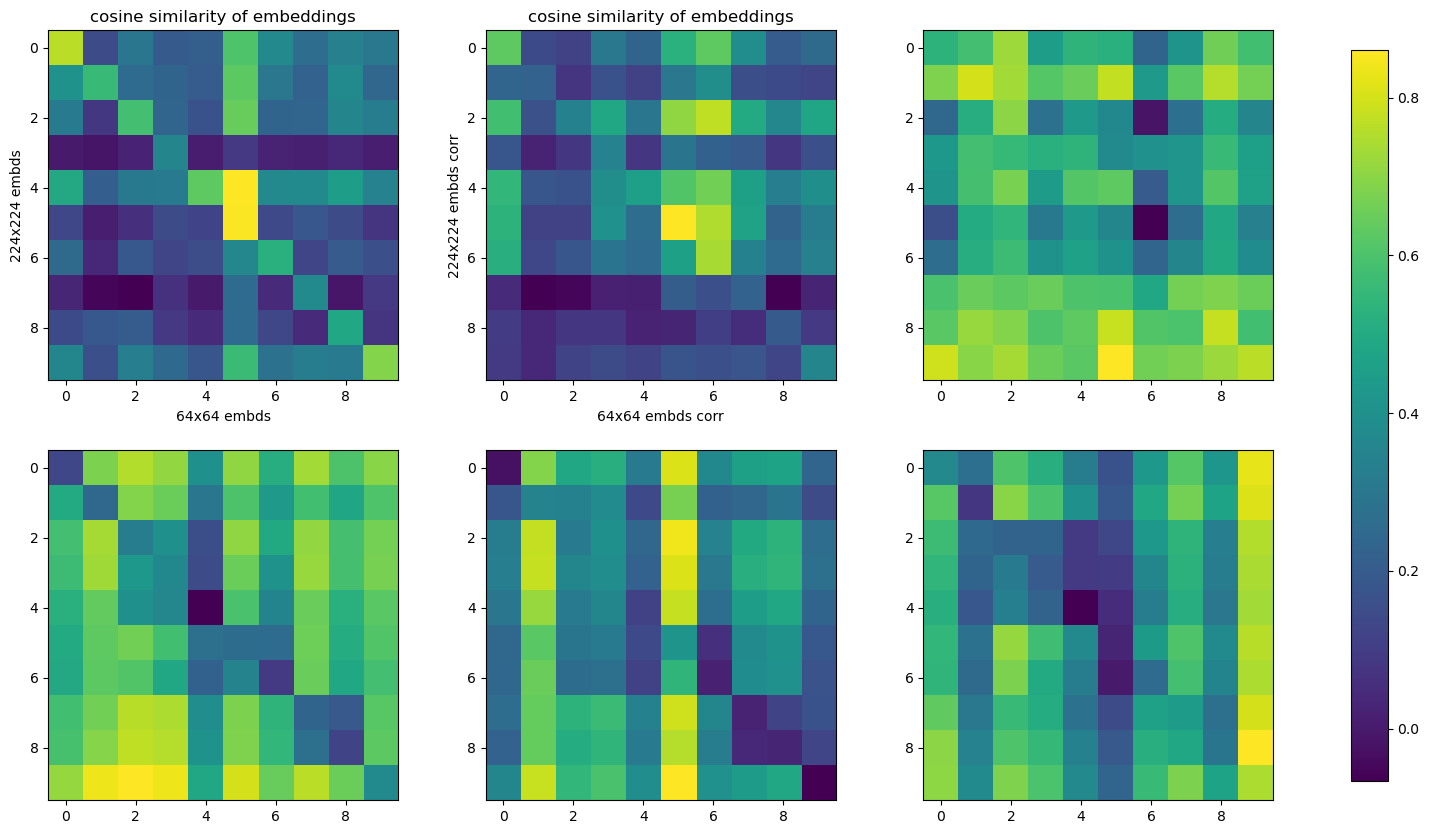

In [280]:
sim_mat = (means/torch.norm(means,dim=1)[:,None]).T@(means64/torch.norm(means64,dim=1)[:,None])
sim_mat2 = (corr_means/torch.norm(corr_means,dim=1)[:,None]).T@(corr_means64/torch.norm(corr_means64,dim=1)[:,None])

sim_mat_e = torch.cdist(means,means64)
sim_mat2_e = torch.cdist(corr_means,corr_means64)
fig,ax = plt.subplots(2,3,figsize=(20,10))
ax[0,0].imshow(sim_mat[:10,:10])
ax[0,0].set_xlabel("64x64 embds")
ax[0,0].set_ylabel("224x224 embds")
ax[0,0].set_title("cosine similarity of embeddings")
im = ax[0,1].imshow(sim_mat2[:10,:10])
ax[0,1].set_xlabel("64x64 embds corr")
ax[0,1].set_ylabel("224x224 embds corr")
ax[0,1].set_title("cosine similarity of embeddings")
ax[0,2].imshow(sim_mat[:10,:10]-sim_mat2[:10,:10])
ax[1,0].imshow(sim_mat_e[:10,:10])
ax[1,1].imshow(sim_mat2_e[:10,:10])
ax[1,2].imshow(sim_mat_e[:10,:10]-sim_mat2_e[:10,:10])
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.95)

# Set the data ordering

In [282]:
from torch.utils.data import Subset

from torch.utils.data.sampler import Sampler

class CustomOrder(Sampler):
    def __init__(self, dataset):
        self.order = torch.randperm(len(dataset),)
        
    def __iter__(self):
        return iter(self.order)
    
    def __len__(self):
        return len(self.order)

rand_order = CustomOrder(clean_val_loader.dataset)
rand_corr_order = torch.randperm(15)

In [141]:
import copy
model64_KD = copy.deepcopy(model64)
model64_KD.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

# Online Euclidean
Distance from teacher to student
1. clean --> clean
2. clean --> corr1
3. clean --> corr2

In [ ]:
num_imgs = 0
transition_points = [1999]
corr_idx = 0
corr_img_count = 0
idxs = []
distances = torch.zeros(50000)
cos_sim = torch.zeros(50000)
rand_order = CustomOrder(clean_val_loader.dataset)
rand_corr_order = torch.randperm(15)
embds,labels = torch.load("embds/clean224.pt")
embds64,labels64 = torch.load("embds/clean64.pt")

for i in range(16):
    for sample_idx in tqdm(rand_order[:5200]):
        # corruptions start after the first 2000 images
        if num_imgs-1 > 1999:
            if corr_img_count == 0:
                corr_embds,corr_labels = torch.load("embds/clean224.pt")
                corr_embds64,corr_labels64 = torch.load("embds/clean64.pt")
            # each corruption lasts 3200 images
            if corr_img_count == 3200:
                corr_idx += 1
                corr_img_count = 0
                transition_points.append(num_imgs)
                corr_embds,corr_labels = torch.load("embds/corr224_"+corruptions[i-1]+".pt")
                corr_embds64,corr_labels64 = torch.load("embds/corr64_"+corruptions[i-1]+".pt")
            # get the image at the specified index
            emb = corr_embds[sample_idx]
            target = corr_labels[sample_idx]
            emb64 = corr_embds64[sample_idx]
            target64 = corr_labels64[sample_idx]
            corr_img_count += 1
        else:
            emb = embds[sample_idx]
            target = labels[sample_idx]
            emb64 = embds64[sample_idx]
            target64 = labels64[sample_idx]

        num_imgs += 1

        distances[num_imgs-1] = (emb-emb64).pow(2).sum(dim=1).sqrt()
        cos_sim[num_imgs-1] = ((emb64/emb64.norm()) @ (emb/emb.norm()).T)
        
        idxs.append(num_imgs)

# Online distance

In [76]:
num_imgs = 0
transition_points = [1999]
corr_idx = 0
corr_img_count = 0
idxs = []
distances = torch.zeros(50000)
cos_sim = torch.zeros(50000)
corr_online_acc_KD = []

for sample_idx in tqdm(rand_order):
    # corruptions start after the first 500 images
    if num_imgs-1 > 1999:
        # each corruption lasts 3300 images
        if corr_img_count == 3200:
            corr_idx += 1
            corr_img_count = 0
            transition_points.append(num_imgs)
        # get the image at the specified index
        img,target = corr_val_loaders[rand_corr_order[corr_idx]].dataset[sample_idx]
        img64,target64 = corr_val_loaders64[rand_corr_order[corr_idx]].dataset[sample_idx]
        img,target = img.to('cuda'),torch.tensor(target).to('cuda')
        img64,target64 = img64.to('cuda'),torch.tensor(target64).to('cuda')
        corr_img_count += 1
    else:
        img,target = clean_val_loader.dataset[sample_idx]
        img64,target64 = clean_val_loader64.dataset[sample_idx]
        img,target = img.to('cuda'),torch.tensor(target).to('cuda')
        img64,target64 = img64.to('cuda'),torch.tensor(target64).to('cuda')

    num_imgs += 1

    # get the prediction of small model
    out64 = model64_KD(img64.unsqueeze(0))
    pred64 = out64.argmax(dim=1).item()
    res64 = (pred64 == target64.item())
    

    # get the embedding
    model64(img64.unsqueeze(0))
    model64_emb = activationS['emb'].to('cpu')

    model(img.unsqueeze(0))
    model_emb = activationT['emb'].to('cpu')

    distances[num_imgs-1] = (model_emb-model64_emb).pow(2).sum(dim=1).sqrt()
    cos_sim[num_imgs-1] = ((model64_emb/model64_emb.norm()) @ (model_emb/model_emb.norm()).T)
    
    idxs.append(num_imgs)

100%|██████████| 50000/50000 [10:12<00:00, 81.59it/s]


In [184]:
run = []
tot = 0
run_std = 0
from collections import deque 
deq = deque(maxlen=100)
deq2 = deque(maxlen=100)
run2 = [0]
blip = []
import math
for i,it in enumerate(cos_sim):
    if i % 10 == 0:
        # update the running mean
        tot = 0.95*tot + 0.05*it
        run.append(tot)
        deq.append(tot)
        deq2.append(tot)
        # update the running std
        if len(deq) > 1:
            s0 = len(deq)
            s1 = sum(x for x in deq)
            s2 = sum(x*x for x in deq)
            run_std = math.sqrt((s0 * s2 - s1 * s1)/(s0 * (s0 - 1)))
            run2.append(run_std)
        if len(deq) == 100:
            if abs(deq2[0]-deq2[99]) > 4*run_std:
                blip.append(i)

    else:
        run.append(tot)
        run2.append(run_std)

(0.0, 30000.0)

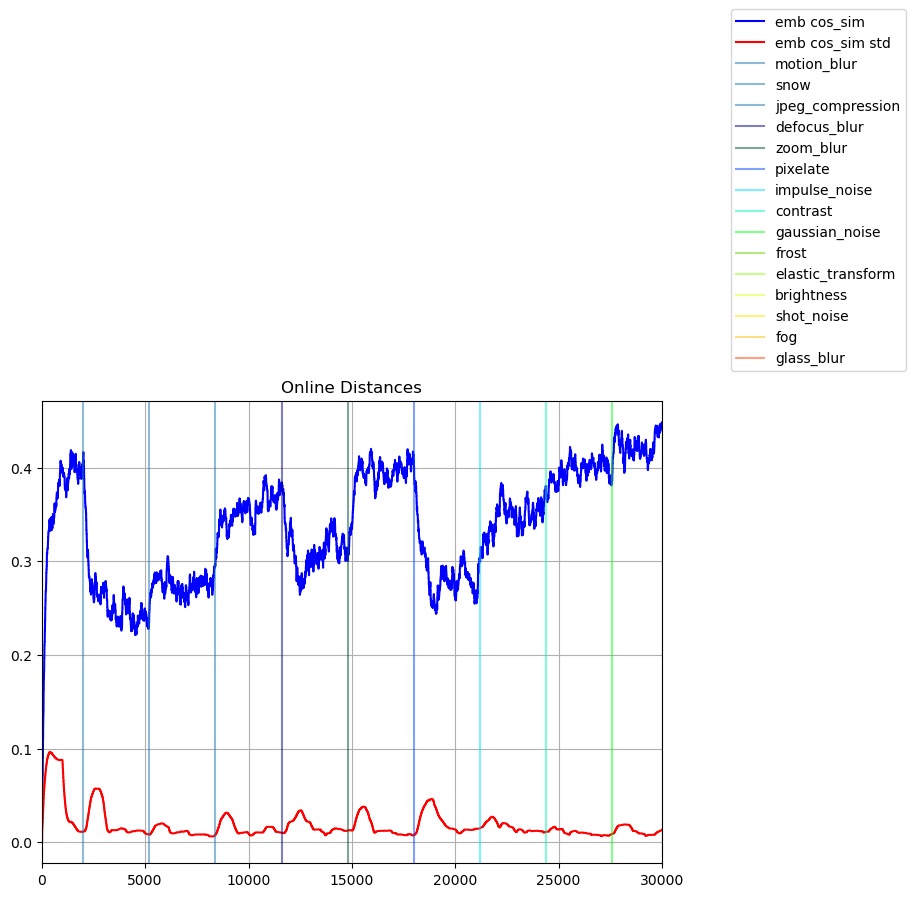

In [188]:
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_subplot(111)
# ax1.plot(idxs,distances,label='emb distances',color='red')
ax1.plot(idxs,run,label='emb cos_sim',color='blue')
ax1.plot(idxs,run2,label='emb cos_sim std',color='red')
# for i,x in enumerate(blip):
#     plt.axvline(x =x,color='k')
# ax1.axvline(x = transition_points[0], color = 'orange', label = 'start corruption')
for i,x in enumerate(transition_points[0:]):
    plt.axvline(x =x, label = corruptions[rand_corr_order[i]],alpha=0.5)
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]
for i,j in enumerate(ax1.lines[5:]):
    j.set_color(colors[i])

ax1.legend(bbox_to_anchor=(1.1, 1.05))
plt.grid()
plt.title("Online Distances")
# plt.ylim([0,1])
plt.xlim([0,30000])

In [187]:
deq

deque([tensor(0.3308),
       tensor(0.3303),
       tensor(0.3286),
       tensor(0.3306),
       tensor(0.3359),
       tensor(0.3283),
       tensor(0.3244),
       tensor(0.3187),
       tensor(0.3156),
       tensor(0.3149),
       tensor(0.3122),
       tensor(0.3139),
       tensor(0.3161),
       tensor(0.3266),
       tensor(0.3264),
       tensor(0.3215),
       tensor(0.3202),
       tensor(0.3188),
       tensor(0.3215),
       tensor(0.3167),
       tensor(0.3242),
       tensor(0.3255),
       tensor(0.3229),
       tensor(0.3302),
       tensor(0.3360),
       tensor(0.3316),
       tensor(0.3384),
       tensor(0.3413),
       tensor(0.3479),
       tensor(0.3458),
       tensor(0.3411),
       tensor(0.3412),
       tensor(0.3407),
       tensor(0.3327),
       tensor(0.3351),
       tensor(0.3324),
       tensor(0.3293),
       tensor(0.3263),
       tensor(0.3300),
       tensor(0.3273),
       tensor(0.3220),
       tensor(0.3260),
       tensor(0.3200),
       tens